In [1]:
# Colab: ensure CuPy matches the system CUDA
def cupy_has_cuda():
    try:
        import cupy as cp
        return hasattr(cp, "cuda") and hasattr(cp.cuda, "runtime")
    except Exception:
        return False

if not cupy_has_cuda():
    # Remove any stub cupy that lacks CUDA bindings
    !pip -q uninstall -y cupy >/dev/null 2>&1
    # Install the CUDA-enabled build that matches Colab's CUDA 12 runtime
    !pip -q install -U cupy-cuda12x
    import IPython
    IPython.Application.instance().kernel.do_shutdown(True)

In [2]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-26345dbb-60c6-9961-d7ca-6670139cf20a)


In [3]:
# Install dependencies if needed
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install scipy matplotlib pillow tqdm -q
    print("✓ Dependencies installed")

✓ Dependencies installed


In [4]:
!rm -rf /content/cuda-conv

In [5]:
# Option A: Clone from GitHub (replace with your repo URL)
!git clone https://github.com/elcruzo/cuda-conv.git
%cd cuda-conv

Cloning into 'cuda-conv'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 100 (delta 38), reused 84 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (100/100), 95.61 KiB | 19.12 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/cuda-conv


In [6]:
!pip uninstall cupy-cuda11x -y
!pip install cupy-cuda12x -q

print("✓ Installed CuPy for CUDA 12.x")

✓ Installed CuPy for CUDA 12.x


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cupy as cp
from tqdm import tqdm
import time
import sys

# Import our modules
from src.api import convolve, convolve_cpu
from src.presets import get_kernel, list_kernels
from src.timing import benchmark_all, benchmark_kernel_only, print_results

print(f"✓ CuPy version: {cp.__version__}")
rt = cp.cuda.runtime.runtimeGetVersion()
print(f"✓ CUDA runtime: {rt}")
props = cp.cuda.runtime.getDeviceProperties(0)
print(f"✓ GPU: {props['name'].decode()}")

✓ CuPy version: 13.6.0
✓ CUDA runtime: 12090
✓ GPU: Tesla T4


✓ Loaded 512x512 image: (512, 512)
✓ Created 2048x2048 image: (2048, 2048)


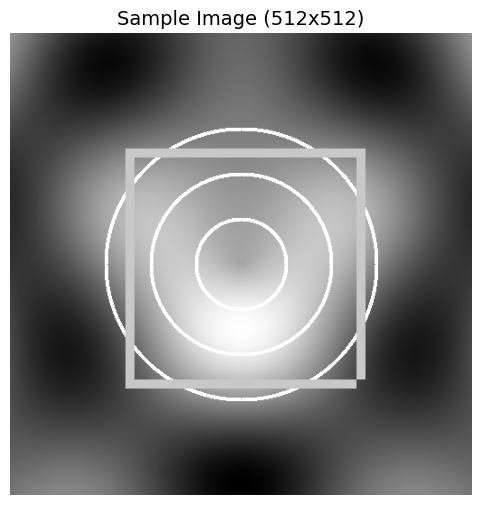

In [8]:
# Load sample images
img_512 = np.array(Image.open('data/lena.png'), dtype=np.float32) / 255.0
print(f"✓ Loaded 512x512 image: {img_512.shape}")

# Create larger test image
from scipy.ndimage import zoom
img_2048 = zoom(img_512, 4, order=1)
print(f"✓ Created 2048x2048 image: {img_2048.shape}")

# Display
plt.figure(figsize=(6, 6))
plt.imshow(img_512, cmap='gray')
plt.title('Sample Image (512x512)', fontsize=14)
plt.axis('off')
plt.show()

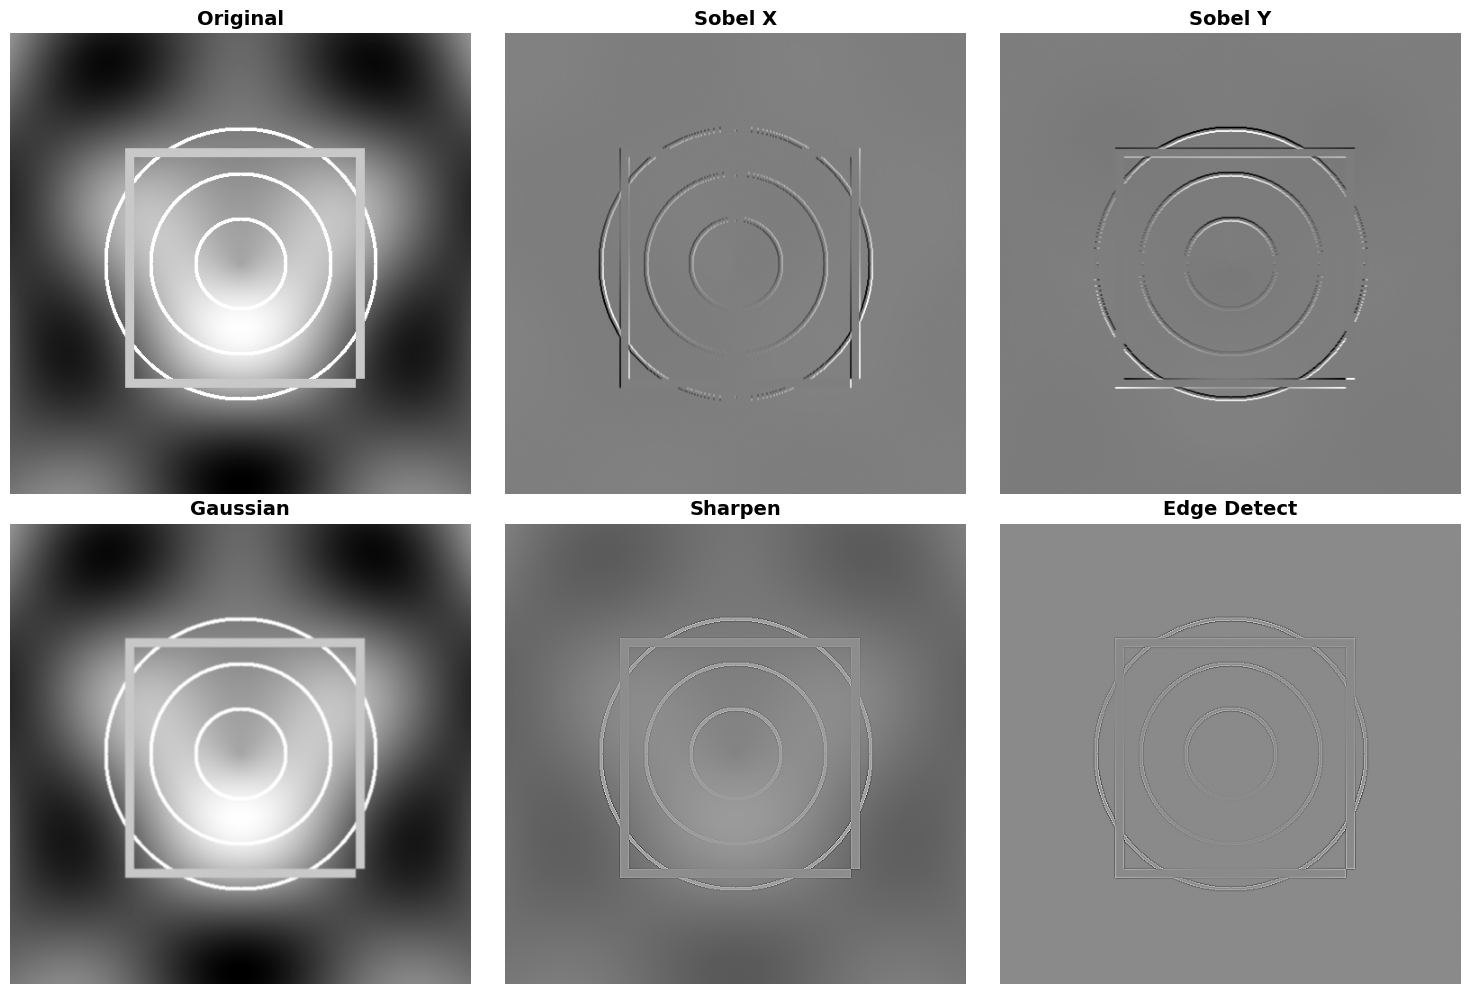

✓ All filters applied successfully!


In [9]:
# Apply different filters
filters = ['sobel_x', 'sobel_y', 'gaussian', 'sharpen', 'edge_detect']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Original
axes[0].imshow(img_512, cmap='gray')
axes[0].set_title('Original', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Apply filters
for i, filter_name in enumerate(filters, start=1):
    kernel = get_kernel(filter_name)
    result = convolve(img_512, kernel, use_shared_mem=True)

    axes[i].imshow(result, cmap='gray')
    axes[i].set_title(filter_name.replace('_', ' ').title(), fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("✓ All filters applied successfully!")

In [10]:
print("="*70)
print("BENCHMARK: 512x512 Image with 3x3 Gaussian Kernel")
print("="*70)

kernel = get_kernel('gaussian')
results_512 = benchmark_all(
    img_512, kernel,
    warmup_runs=3,
    timed_runs=20,
    include_builtin=True
)

print("\n" + "="*70)
print_results(results_512)

BENCHMARK: 512x512 Image with 3x3 Gaussian Kernel
Benchmarking cpu...
Benchmarking gpu_naive...
Benchmarking gpu_optimized...
Benchmarking gpu_builtin...

Method               Time (ms)       Throughput (MP/s)    Speedup   
cpu                       4.191 ms        62.55 MP/s      1.00x     
gpu_naive                 0.712 ms       368.35 MP/s      5.89x     
gpu_optimized             0.723 ms       362.67 MP/s      5.80x     
gpu_builtin               0.842 ms       311.28 MP/s      4.98x     


In [11]:
print("="*70)
print("🎯 MAIN BENCHMARK: 2048x2048 Image (Target: 20x Speedup)")
print("="*70)

results_2048 = benchmark_all(
    img_2048, kernel,
    warmup_runs=3,
    timed_runs=20,
    include_builtin=True
)

print("\n" + "="*70)
print_results(results_2048)

🎯 MAIN BENCHMARK: 2048x2048 Image (Target: 20x Speedup)
Benchmarking cpu...
Benchmarking gpu_naive...
Benchmarking gpu_optimized...
Benchmarking gpu_builtin...

Method               Time (ms)       Throughput (MP/s)    Speedup   
cpu                     192.297 ms        21.81 MP/s      1.00x     
gpu_naive                16.246 ms       258.18 MP/s      11.84x    
gpu_optimized             9.333 ms       449.42 MP/s      20.60x    
gpu_builtin               9.429 ms       444.85 MP/s      20.40x    


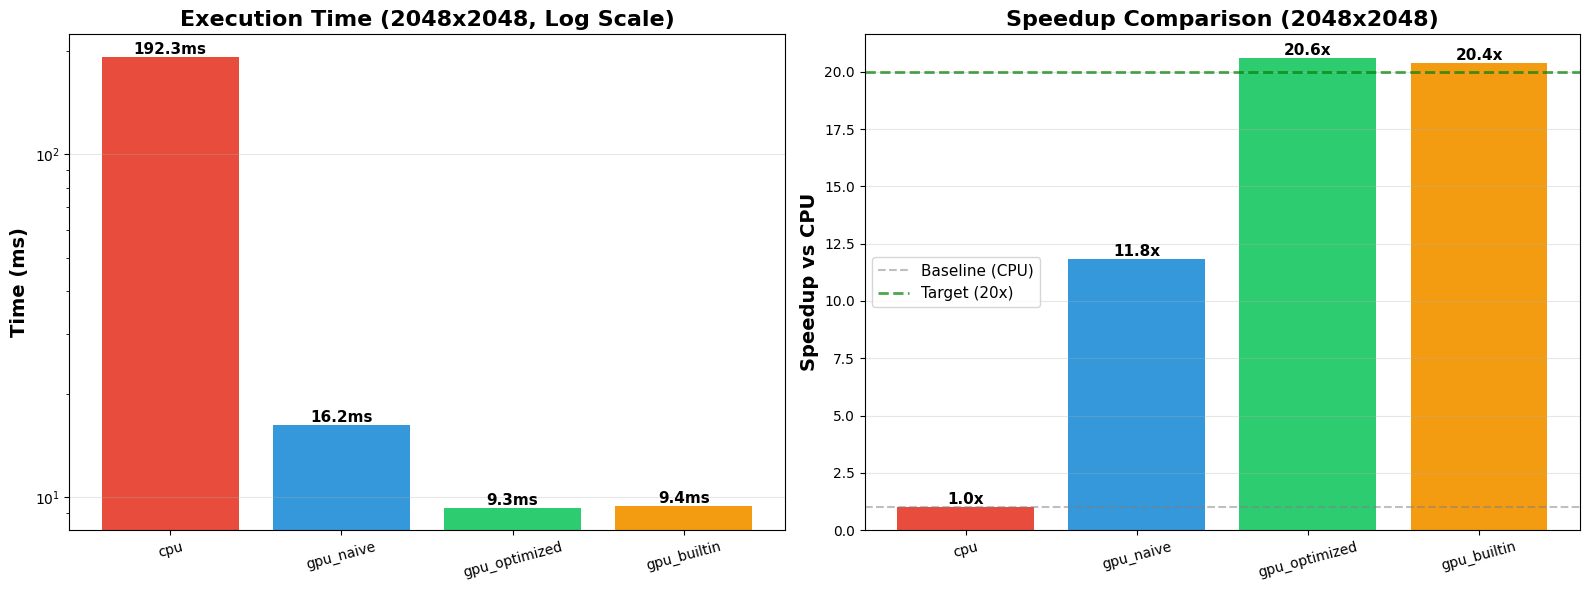


🎉 RESULTS SUMMARY
Best GPU Speedup: 20.60x
Target Achieved: ✅ YES!


In [12]:
from src.timing import calculate_speedup

# Extract data
methods = [r['method'] for r in results_2048]
times_ms = [r['mean_time'] * 1000 for r in results_2048]
speedups = list(calculate_speedup(results_2048, baseline='cpu').values())

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart: Execution time
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
bars1 = ax1.bar(methods, times_ms, color=colors[:len(methods)])
ax1.set_ylabel('Time (ms)', fontsize=14, fontweight='bold')
ax1.set_title('Execution Time (2048x2048, Log Scale)', fontsize=16, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=15)

# Add value labels
for bar, time_ms in zip(bars1, times_ms):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_ms:.1f}ms',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Bar chart: Speedup
bars2 = ax2.bar(methods, speedups, color=colors[:len(methods)])
ax2.set_ylabel('Speedup vs CPU', fontsize=14, fontweight='bold')
ax2.set_title('Speedup Comparison (2048x2048)', fontsize=16, fontweight='bold')
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Baseline (CPU)')
ax2.axhline(y=20, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Target (20x)')
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=11)
ax2.tick_params(axis='x', rotation=15)

# Add value labels
for bar, speedup in zip(bars2, speedups):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{speedup:.1f}x',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
max_speedup = max(speedups)
print("\n" + "="*70)
print("🎉 RESULTS SUMMARY")
print("="*70)
print(f"Best GPU Speedup: {max_speedup:.2f}x")
print(f"Target Achieved: {'✅ YES!' if max_speedup >= 20 else '❌ NO (target: 20x)'}")
print("="*70)